In [1]:
from google.cloud import storage
import os
from io import BytesIO
import pandas as pd

#Connect to GCP bucket and assign the bucket_name and specify the file name
bucket_name = "lich-bucket"
storage_client = storage.Client()

bucket = storage_client.get_bucket(bucket_name)

In [2]:
blob1 = storage.blob.Blob("Classification_Data.csv",bucket)

In [3]:
blob1

<Blob: lich-bucket, Classification_Data.csv, None>

In [4]:
# Convert rating data to pandas dataframes
content = blob1.download_as_string()
df = pd.read_csv(BytesIO(content))
df.head()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Time,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Police_Attend_Scene_of_Accident,weight
0,1,2,1,1,3,1,12,3,3218,1,...,1,1,1,1,1,1,1,1,1,0.135960
1,1,3,1,1,4,1,12,4,450,2,...,1,2,2,2,2,1,1,1,1,0.012925
2,1,3,2,1,5,0,12,5,0,1,...,1,3,2,2,2,1,1,1,1,0.012925
3,1,3,1,1,6,1,12,3,3220,1,...,1,3,1,2,2,1,1,1,1,0.012925
4,1,3,1,1,2,0,12,6,0,1,...,1,3,3,2,1,1,1,1,1,0.012925


In [5]:
# impport everything we need
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# initializing the spark session
spark = SparkSession.builder.appName('classification').getOrCreate()

# Deal with Imbalanced data with SMOTE

In [7]:
X = df.filter(items=['Police_Force','Number_of_Vehicles','Number_of_Casualties',
                     'Day_of_Week','Time','Local_Authority_(District)','1st_Road_Class',
                     '1st_Road_Number','Road_Type','Speed_limit','Pedestrian_Crossing-Human_Control',
                     'Junction_Control','2nd_Road_Class','2nd_Road_Number',
                     'Pedestrian_Crossing-Physical_Facilities','Light_Conditions',
                     'Weather_Conditions','Road_Surface_Conditions','Special_Conditions_at_Site',
                     'Carriageway_Hazards','Urban_or_Rural_Area','Police_Attend_Scene_of_Accident','weight'])
Y = df.filter(items=['Accident_Severity'])
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [8]:
# pip install -U imbalanced-learn

In [9]:
# SMOTE method to deal with imbalance data with oversample
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [10]:
# Combine oversampled datasets
dataframe_1 = pd.DataFrame(x_train_res,columns=['Police_Force','Number_of_Vehicles','Number_of_Casualties',
                                                'Day_of_Week','Time','Local_Authority_(District)','1st_Road_Class',
                                                '1st_Road_Number','Road_Type','Speed_limit',
                                                'Pedestrian_Crossing-Human_Control',
                                                'Junction_Control','2nd_Road_Class','2nd_Road_Number',
                                                'Pedestrian_Crossing-Physical_Facilities','Light_Conditions',
                                                'Weather_Conditions','Road_Surface_Conditions',
                                                'Special_Conditions_at_Site',
                                                'Carriageway_Hazards','Urban_or_Rural_Area',
                                                'Police_Attend_Scene_of_Accident','weight'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['Accident_Severity'])
result = dataframe_1.combine_first(dataframe_2)

In [11]:
# save dataset (in case)
result.to_csv('data.csv', index = False)

In [12]:
df = spark.read.csv('data.csv', header=True)

([<matplotlib.axis.XTick at 0x7f20a36e64d0>,
 <a list of 3 Text xticklabel objects>)

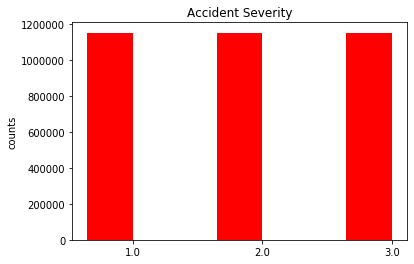

In [13]:
# see the data distribution after SMOTE
responses = df.groupBy('Accident_Severity').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Accident Severity')
plt.xticks(ind + width/2., categories)

# Feature development

In [14]:
# make sure all variable type are double
from pyspark.sql import functions as F

for col in df.columns:
    df = df.withColumn(col,F.col(col).cast("double"))

df.printSchema()

root
 |-- 1st_Road_Class: double (nullable = true)
 |-- 1st_Road_Number: double (nullable = true)
 |-- 2nd_Road_Class: double (nullable = true)
 |-- 2nd_Road_Number: double (nullable = true)
 |-- Accident_Severity: double (nullable = true)
 |-- Carriageway_Hazards: double (nullable = true)
 |-- Day_of_Week: double (nullable = true)
 |-- Junction_Control: double (nullable = true)
 |-- Light_Conditions: double (nullable = true)
 |-- Local_Authority_(District): double (nullable = true)
 |-- Number_of_Casualties: double (nullable = true)
 |-- Number_of_Vehicles: double (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: double (nullable = true)
 |-- Pedestrian_Crossing-Physical_Facilities: double (nullable = true)
 |-- Police_Attend_Scene_of_Accident: double (nullable = true)
 |-- Police_Force: double (nullable = true)
 |-- Road_Surface_Conditions: double (nullable = true)
 |-- Road_Type: double (nullable = true)
 |-- Special_Conditions_at_Site: double (nullable = true)
 |-- Speed_li

In [15]:
# transform all independents into a vector and put into a new column named 'features'
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Police_Force','Number_of_Vehicles','Number_of_Casualties',
                                       'Day_of_Week','Time','Local_Authority_(District)','1st_Road_Class',
                                       '1st_Road_Number','Road_Type','Speed_limit','Pedestrian_Crossing-Human_Control',
                                       'Junction_Control','2nd_Road_Class','2nd_Road_Number',
                                       'Pedestrian_Crossing-Physical_Facilities','Light_Conditions',
                                       'Weather_Conditions','Road_Surface_Conditions','Special_Conditions_at_Site',
                                       'Carriageway_Hazards','Urban_or_Rural_Area','Police_Attend_Scene_of_Accident'],
                            outputCol="features")
df = assembler.transform(df)
# rename to label
df = df.withColumnRenamed("Accident_Severity","label")
df.printSchema()

root
 |-- 1st_Road_Class: double (nullable = true)
 |-- 1st_Road_Number: double (nullable = true)
 |-- 2nd_Road_Class: double (nullable = true)
 |-- 2nd_Road_Number: double (nullable = true)
 |-- label: double (nullable = true)
 |-- Carriageway_Hazards: double (nullable = true)
 |-- Day_of_Week: double (nullable = true)
 |-- Junction_Control: double (nullable = true)
 |-- Light_Conditions: double (nullable = true)
 |-- Local_Authority_(District): double (nullable = true)
 |-- Number_of_Casualties: double (nullable = true)
 |-- Number_of_Vehicles: double (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: double (nullable = true)
 |-- Pedestrian_Crossing-Physical_Facilities: double (nullable = true)
 |-- Police_Attend_Scene_of_Accident: double (nullable = true)
 |-- Police_Force: double (nullable = true)
 |-- Road_Surface_Conditions: double (nullable = true)
 |-- Road_Type: double (nullable = true)
 |-- Special_Conditions_at_Site: double (nullable = true)
 |-- Speed_limit: double 

# Modeling

In [16]:
# split data 70%/30%
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=0)

In [17]:
# check training and testing data size
#trainingData.count(), testData.count()

# (2419854, 1036428)

In [18]:
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier # not appliable because only support binary
from pyspark.ml.classification import LogisticRegression

from pyspark.sql.functions import avg
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

### Decision Tree

In [19]:
# decision tree approach
# define model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [20]:
# set up pipeline
pipeline_dt = Pipeline(stages=[dt])

In [21]:
# fit training data
model_dt = pipeline_dt.fit(trainingData)

In [22]:
# make prediction on test data
predictions_dt = model_dt.transform(testData)

In [23]:
# get actual value
y_true = predictions_dt.select("label")
y_true = y_true.toPandas()

In [24]:
# get prediction
y_pred = predictions_dt.select("prediction")
y_pred = y_pred.toPandas()

In [25]:
# set up index for confusion matrix
class_temp = predictions_dt.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

In [26]:
# a raw output of confusion matrix
from sklearn.metrics import confusion_matrix
dt_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
dt_matrix

array([[253970,  60042,  31613],
       [137045, 110064,  98334],
       [ 64687,  64496, 216177]])

In [27]:
# function used to plot matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.73481374 0.17372007 0.09146618]
 [0.39672247 0.31861696 0.28466057]
 [0.1873031  0.18675006 0.62594684]]


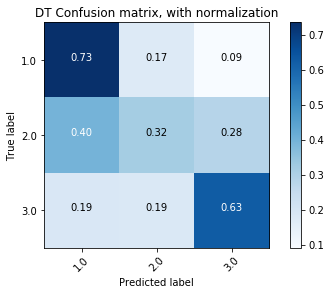

In [28]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(dt_matrix, classes=class_temp,normalize=True,
                      title='DT Confusion matrix, with normalization')
plt.show()

In [ ]:
#evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#accuracy_dt = evaluator.evaluate(predictions_dt)
#accuracy_dt

In [32]:
# get accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy_dt = evaluator.evaluate(predictions_dt)
accuracy_dt

0.5598179516570374

In [41]:
# get f1
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
f1_dt = evaluator.evaluate(predictions_dt)
f1_dt

0.5462191974077444

### Random Forest

In [42]:
# random forest approach
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline_rf = Pipeline(stages=[rf])

In [43]:
model_rf = pipeline_rf.fit(trainingData)

In [44]:
predictions_rf = model_rf.transform(testData)

In [45]:
y_true = predictions_rf.select("label")
y_true = y_true.toPandas()

In [46]:
y_pred = predictions_rf.select("prediction")
y_pred = y_pred.toPandas()

In [47]:
class_temp = predictions_rf.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

In [48]:
rf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
rf_matrix

array([[248302,  62241,  35082],
       [126755, 121820,  96868],
       [ 65878,  64881, 214601]])

Normalized confusion matrix
[[0.71841447 0.18008246 0.10150307]
 [0.36693463 0.35264863 0.28041674]
 [0.19075168 0.18786484 0.62138348]]


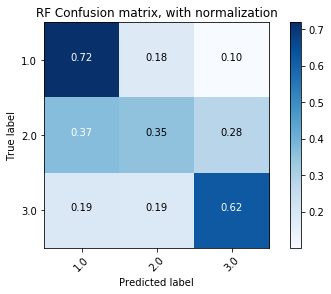

In [49]:
plt.figure()
plot_confusion_matrix(rf_matrix, classes=class_temp,normalize=True,
                      title='RF Confusion matrix, with normalization')
plt.show()

In [50]:
#evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#accuracy_rf = evaluator.evaluate(predictions_rf)
#accuracy_rf

In [51]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_rf

0.5641713654976516

In [52]:
# get f1
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
f1_rf = evaluator.evaluate(predictions_rf)
f1_rf

0.5538677666085999

### logistic regression

In [53]:
# Gradient-boosted tree approach
lr = LogisticRegression(labelCol="label", featuresCol="features", family="multinomial")
pipeline_lr = Pipeline(stages=[lr])

In [54]:
model_lr = pipeline_lr.fit(trainingData)

In [55]:
predictions_lr = model_lr.transform(testData)

In [56]:
y_true = predictions_lr.select("label")
y_true = y_true.toPandas()

In [57]:
y_pred = predictions_lr.select("prediction")
y_pred = y_pred.toPandas()

In [58]:
class_temp = predictions_lr.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

In [59]:
lr_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
lr_matrix

array([[229735,  77768,  38122],
       [116681, 128404, 100358],
       [ 56068,  66024, 223268]])

Normalized confusion matrix
[[0.66469439 0.22500687 0.11029873]
 [0.33777208 0.37170821 0.29051971]
 [0.16234654 0.19117443 0.64647904]]


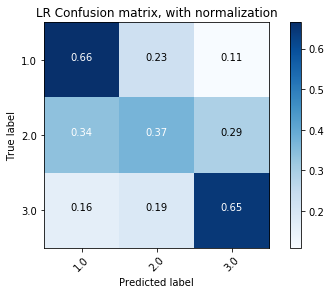

In [60]:
plt.figure()
plot_confusion_matrix(lr_matrix, classes=class_temp,normalize=True,
                      title='LR Confusion matrix, with normalization')
plt.show()

In [61]:
#evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#accuracy_lr = evaluator.evaluate(predictions_lr)
#accuracy_lr

In [62]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_lr

0.5609719150775548

In [63]:
# get f1
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
f1_lr = evaluator.evaluate(predictions_lr)
f1_lr

0.5538247753068419

# Evaluation

In [67]:
print('Decision Tree Model:')
print('The accuracy is ' + str(accuracy_dt))
print('The F1 score is ' + str(f1_dt))
print('-----------------------------------')
print('Random Forest Model:')
print('The accuracy is ' + str(accuracy_rf))
print('The F1 score is ' + str(f1_rf))
print('-----------------------------------')
print('Logistic Regression Model:')
print('The accuracy is ' + str(accuracy_lr))
print('The F1 score is ' + str(f1_lr))

Decision Tree Model:
The accuracy is 0.5598179516570374
The F1 score is 0.5462191974077444
-----------------------------------
Random Forest Model:
The accuracy is 0.5641713654976516
The F1 score is 0.5538677666085999
-----------------------------------
Logistic Regression Model:
The accuracy is 0.5609719150775548
The F1 score is 0.5538247753068419


Normalized confusion matrix
[[0.73481374 0.17372007 0.09146618]
 [0.39672247 0.31861696 0.28466057]
 [0.1873031  0.18675006 0.62594684]]


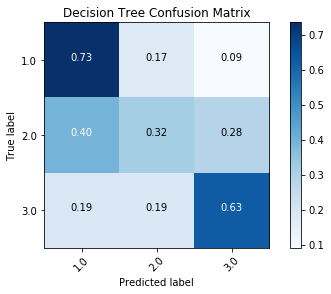

In [68]:
# DT
plt.figure()
plot_confusion_matrix(dt_matrix, classes=class_temp,normalize=True,
                      title='Decision Tree Confusion Matrix')
plt.show()

Normalized confusion matrix
[[0.71841447 0.18008246 0.10150307]
 [0.36693463 0.35264863 0.28041674]
 [0.19075168 0.18786484 0.62138348]]


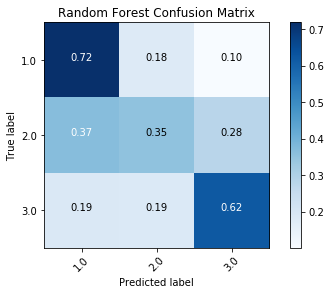

In [69]:
# RF
plt.figure()
plot_confusion_matrix(rf_matrix, classes=class_temp,normalize=True,
                      title='Random Forest Confusion Matrix')
plt.show()

Normalized confusion matrix
[[0.66469439 0.22500687 0.11029873]
 [0.33777208 0.37170821 0.29051971]
 [0.16234654 0.19117443 0.64647904]]


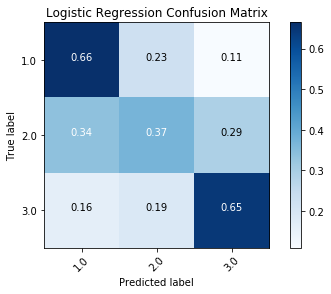

In [70]:
# LR
plt.figure()
plot_confusion_matrix(lr_matrix, classes=class_temp,normalize=True,
                      title='Logistic Regression Confusion Matrix')
plt.show()

In [71]:
output = pd.DataFrame()
Model = ['Decision Tree','Random Forest', 'Logistic Regression']
Accuracy = [accuracy_dt, accuracy_rf, accuracy_lr]
F1_Score = [f1_dt, f1_rf, f1_lr]
output['Model'] = Model
output['Accuracy'] = Accuracy
output['F1 Score'] = F1_Score
output

,Model,Accuracy,F1 Score
0,Decision Tree,0.559818,0.546219
1,Random Forest,0.564171,0.553868
2,Logistic Regression,0.560972,0.553825


In [72]:
# save results
output.to_csv('Project_results.csv', index = False)